The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 2/2 [01:23<00:00, 42.00s/it]


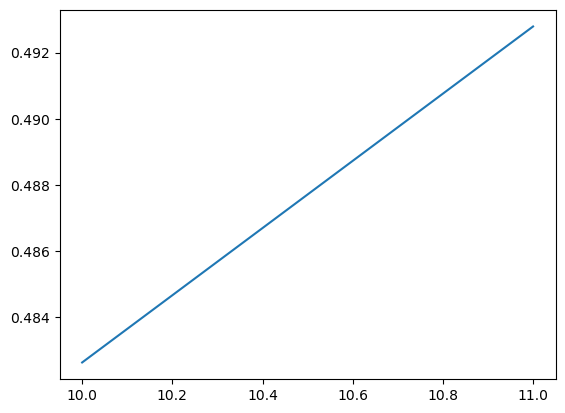

In [81]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
#model and 
from utils import *
from tqdm import tqdm
from models import MSE,MDcR,DSE,MVBG,PCA,MVP

X,labels=read_data('datasets/data sets/MSRC-v1.mat')
X = [X[0,i].T for  i  in range(X.shape[1])]
labels  = labels.squeeze()
model_MSE = MSE()
model_MDcR = MDcR()
model_DSE = DSE()
model_MVBG = MVBG(1,1,1)
model_PCA = PCA()
model_MVP =  MVP()

res_nim = []
d_range  = range(10,12)
for d_ in tqdm(d_range): 
    nmi_list = []
    for i in range(20):
        # train_test split
        train_idx,test_idx = random_index(X[0].shape[1],0.8)
        X_train = [x[:,train_idx] for x in X]
        X_test = [x[:,test_idx] for x in X]
        y_test = labels[test_idx]
        #train
        # P = model_MSE.mse(X,gamma = 0.9,d_=d_,t=1e8,epoch=500)
        # P = model_MDcR.mdcr(X,d_=10,t=1e8,lmd=10,epoch=500)
        # P   = model_PCA.cpca(X_train,d_=d_)

        #test
        pred =  model_MVP.predict(X_test,0.5,1,1e8,10,d_,50)
        # criterion
        from sklearn.metrics.cluster import normalized_mutual_info_score
        nmi = normalized_mutual_info_score(y_test,pred)
        nmi_list.append(nmi)
    nmi = np.mean(nmi_list)
    res_nim.append(nmi)
# res_nim
import matplotlib.pyplot as plt
plt.plot(d_range,res_nim)


In [ ]:
#MVBG
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
#model and 
from utils import *
from tqdm import tqdm
from models import MSE,MDcR,DSE,MVBG,PCA
from sklearn.metrics.cluster import normalized_mutual_info_score
X,labels=read_data('datasets/data sets/NGs.mat')
X = [X[0,i].T for  i  in range(X.shape[1])]
labels  = labels.squeeze()

d_range = (10,12)
model_mvbg = MVBG(0.1,2,0.1)
res_nmi = []
for d_ in d_range:
    nmi_list=[]
    for _ in range(1):
        dim_emb = model_mvbg.mvbg(X,100,d_,10)
        pred =kmeans(dim_emb,7)
        nmi_temp = normalized_mutual_info_score(labels, pred)
        nmi_list.append(nmi_temp)
    nmi = np.mean(nmi_list)
    res_nmi.append(nmi)
print(res_nmi)

In [ ]:
#DSE 單獨
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

from utils import *
from tqdm import tqdm
X,labels=read_data('datasets/data sets/YALE.mat')
X = [X[0,i].T for  i  in range(X.shape[1])]
labels  = labels.squeeze()

from models import DSE
model_DSE = DSE()
nmi_list=[]

for _ in tqdm(range(20)):

    pred = model_DSE.dse(X,7,2,500)
    from sklearn.metrics.cluster import normalized_mutual_info_score
    nmi = normalized_mutual_info_score(labels,pred)
    # print(nmi)
    nmi_list.append(nmi)
print(np.mean(nmi_list))

In [ ]:
labels.shape

In [ ]:
x=np.random.rand(3,4)
np.exp(x)/np.exp(x).sum(1).reshape(3,-1)